In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pandas as pd

In [2]:
def rosenbrock(x):
    '''
    x is a numpy array of shape (2,)
    '''
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2

In [3]:
def get_next_point(x_cur,sigma,n_samples,goodness_ratio,max_retry=1000):
    '''
    x_cur is a numpy array of shape (2,)
    sigma is the standard deviation for the Gaussian distribution
    x_godd<=goodness_ratio*x_cur
    '''
    while True:
        samples = np.random.normal(x_cur, sigma, (n_samples, 2)) # shape (n_samples, 2)
        good_samples = samples[np.array([rosenbrock(x) <= goodness_ratio * rosenbrock(x_cur) for x in samples])]
        bad_samples = samples[np.array([rosenbrock(x) > goodness_ratio * rosenbrock(x_cur) for x in samples])]
        max_retry -= 1
        if len(good_samples)> 0:
            break
        if max_retry == 0: # no good samples found fall back to the best sample available
            scores = np.array([rosenbrock(x) for x in samples])
            return samples[np.argmin(scores)]
    good_density = KernelDensity()
    good_density.fit(good_samples)
    if len(bad_samples) > 0:
        bad_density = KernelDensity()
        bad_density.fit(bad_samples)
        improvement_score = good_density.score_samples(good_samples) - bad_density.score_samples(good_samples)
    else:
        improvement_score = good_density.score_samples(good_samples)
    return good_samples[np.argmax(improvement_score)]

In [4]:
def bayesian_opt(x0, sigma, n_samples, max_iter=5000, goodness_ratio=0.9, tol=1e-4,seed=42):
    np.random.seed(seed)
    x_cur = x0
    path_list = [x_cur]
    for _ in range(max_iter):
        x_next = get_next_point(x_cur, sigma, n_samples, goodness_ratio)
        path_list.append(x_next)
        if rosenbrock(path_list[-1]) < tol:
            break
        x_cur = x_next
    return np.array(path_list)

In [5]:
x0 = np.array([-1.0,-1.0])

In [6]:
path_arr = bayesian_opt(x0, sigma=1, n_samples=100, max_iter=5000, goodness_ratio=0.9)

In [7]:
test_random_seed_list = [1, 2, 3, 4,5,6,7,8,9,10]
test_sigma_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [8]:
store_path_dict = {}

In [9]:
for test_random_seed in test_random_seed_list:
    for test_sigma in test_sigma_list:
        path_arr = bayesian_opt(x0, sigma=test_sigma, n_samples=100, max_iter=5000, goodness_ratio=0.9, seed=test_random_seed)
        store_path_dict[(test_random_seed, test_sigma)] = path_arr

In [10]:
# Create a dataframe from the store_path_dict
data = []
for (seed, sigma), path in store_path_dict.items():
    data.append({
        'test_seed': seed,
        'sigma': sigma,
        'path_length': len(path)
    })

# Convert to a pandas dataframe
df = pd.DataFrame(data)

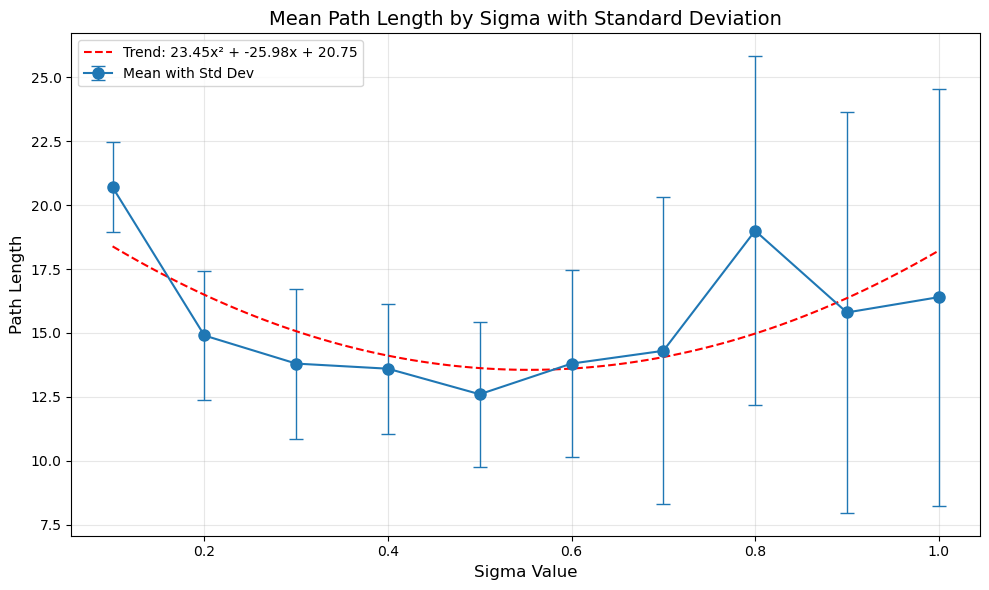

In [11]:
# Calculate the statistics grouped by sigma
df_stats = df.groupby('sigma').agg({
    'path_length': ['mean', 'std']
}).reset_index()

# Flatten the multi-level column names
df_stats.columns = ['sigma', 'mean', 'std']

# Create a single plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(df_stats['sigma'], df_stats['mean'], yerr=df_stats['std'], 
             fmt='o-', capsize=5, markersize=8, elinewidth=1, label='Mean with Std Dev')

# Add trendline (polynomial fit)
z = np.polyfit(df_stats['sigma'], df_stats['mean'], 2)
p = np.poly1d(z)
x_trend = np.linspace(min(df_stats['sigma']), max(df_stats['sigma']), 100)
plt.plot(x_trend, p(x_trend), 'r--', label=f'Trend: {z[0]:.2f}x² + {z[1]:.2f}x + {z[2]:.2f}')

plt.xlabel('Sigma Value', fontsize=12)
plt.ylabel('Path Length', fontsize=12)
plt.title('Mean Path Length by Sigma with Standard Deviation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
shortest_path_params = min(store_path_dict, key=lambda x: store_path_dict[x].shape[0])
longest_path_params = max(store_path_dict, key=lambda x: store_path_dict[x].shape[0])
shortest_path = store_path_dict[shortest_path_params]
longest_path = store_path_dict[longest_path_params]

In [13]:
print(f"Shortest Path Parameters: {shortest_path_params}, Length: {shortest_path.shape[0]}")
print(f"Longest Path Parameters: {longest_path_params}, Length: {longest_path.shape[0]}")

Shortest Path Parameters: (2, 0.7), Length: 6
Longest Path Parameters: (2, 1), Length: 34


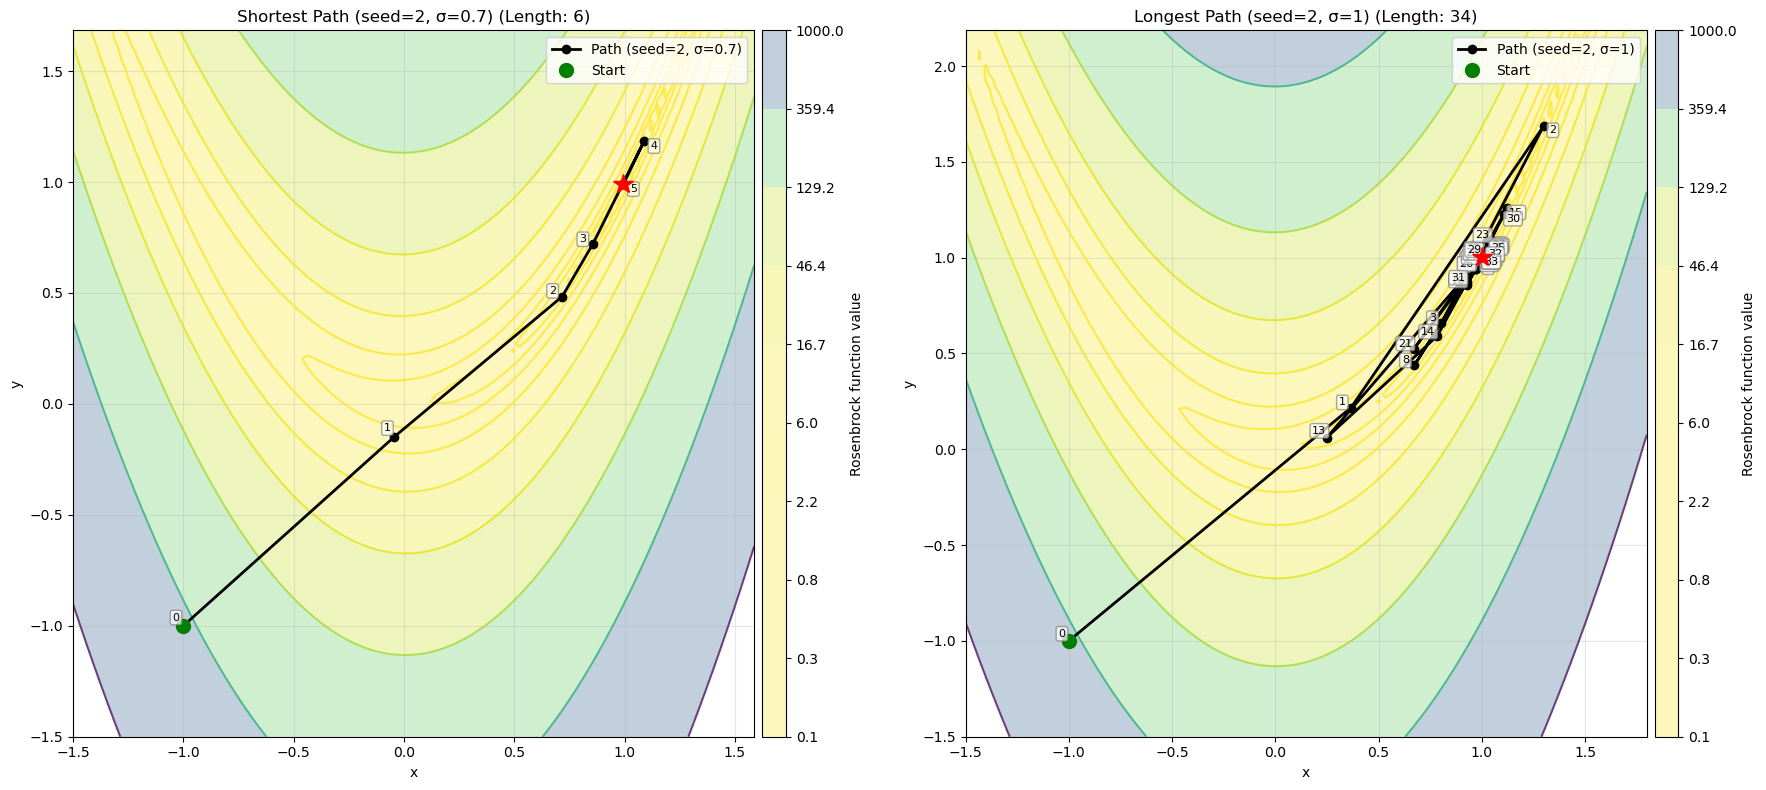

In [14]:
# Create a figure with two subplots to compare shortest and longest paths
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Function to plot a path on a given axis with iteration numbers
def plot_path_with_iterations(path, params, ax, title):
    # Set the range for the contour plot
    x_min_plot = min(path[:, 0]) - 0.5
    x_max_plot = max(path[:, 0]) + 0.5
    y_min_plot = min(path[:, 1]) - 0.5
    y_max_plot = max(path[:, 1]) + 0.5

    # Create a grid of points
    x_grid = np.linspace(x_min_plot, x_max_plot, 100)
    y_grid = np.linspace(y_min_plot, y_max_plot, 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Calculate the Rosenbrock function value for each point
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = rosenbrock(np.array([X[i, j], Y[i, j]]))

    # Create a contour plot with logarithmic scale
    contour_levels = np.logspace(-1, 3, 10)
    contour = ax.contour(X, Y, Z, levels=contour_levels, cmap='viridis_r', alpha=0.7)
    cf = ax.contourf(X, Y, Z, levels=contour_levels, cmap='viridis_r', alpha=0.3)
    
    # Plot the path as a black line with markers
    ax.plot(path[:, 0], path[:, 1], 'k-o', linewidth=2, markersize=6, 
         label=f'Path (seed={params[0]}, σ={params[1]})')
    
    # Mark iterations with numbers, with slight offset for better visibility
    for i, (x, y) in enumerate(path):
        # Calculate offset direction based on path direction
        if i < len(path) - 1:
            dx = path[i+1, 0] - x
            dy = path[i+1, 1] - y
        else:
            dx = x - path[i-1, 0]
            dy = y - path[i-1, 1]
            
        # Normalize and apply offset
        norm = np.sqrt(dx**2 + dy**2) + 1e-10  # Avoid division by zero
        offset_x = 0.05 * (-dy/norm)
        offset_y = 0.05 * (dx/norm)
        
        ax.annotate(str(i), (x + offset_x, y + offset_y), fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))
    
    # Mark the start and end points
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=10, label='Start')
    
    # Add title and labels
    ax.set_title(f'{title} (Length: {len(path)})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return cf

# Plot the shortest path on the first subplot
cf0 = plot_path_with_iterations(shortest_path, shortest_path_params, ax[0], 
                                f'Shortest Path (seed={shortest_path_params[0]}, σ={shortest_path_params[1]})')

# Plot the longest path on the second subplot
cf1 = plot_path_with_iterations(longest_path, longest_path_params, ax[1], 
                                f'Longest Path (seed={longest_path_params[0]}, σ={longest_path_params[1]})')

# Add the end points last (on top of everything else) to ensure they're visible
ax[0].plot(shortest_path[-1, 0], shortest_path[-1, 1], 'r*', markersize=15, label='End', zorder=10)
ax[1].plot(longest_path[-1, 0], longest_path[-1, 1], 'r*', markersize=15, label='End', zorder=10)

# Add a colorbar for each plot
cbar0 = fig.colorbar(cf0, ax=ax[0], pad=0.01, aspect=30, label='Rosenbrock function value')
cbar1 = fig.colorbar(cf1, ax=ax[1], pad=0.01, aspect=30, label='Rosenbrock function value')

plt.tight_layout()
plt.show()


Shortest path for sigma=0.5: seed=2, length=10
Longest path for sigma=0.5: seed=6, length=17


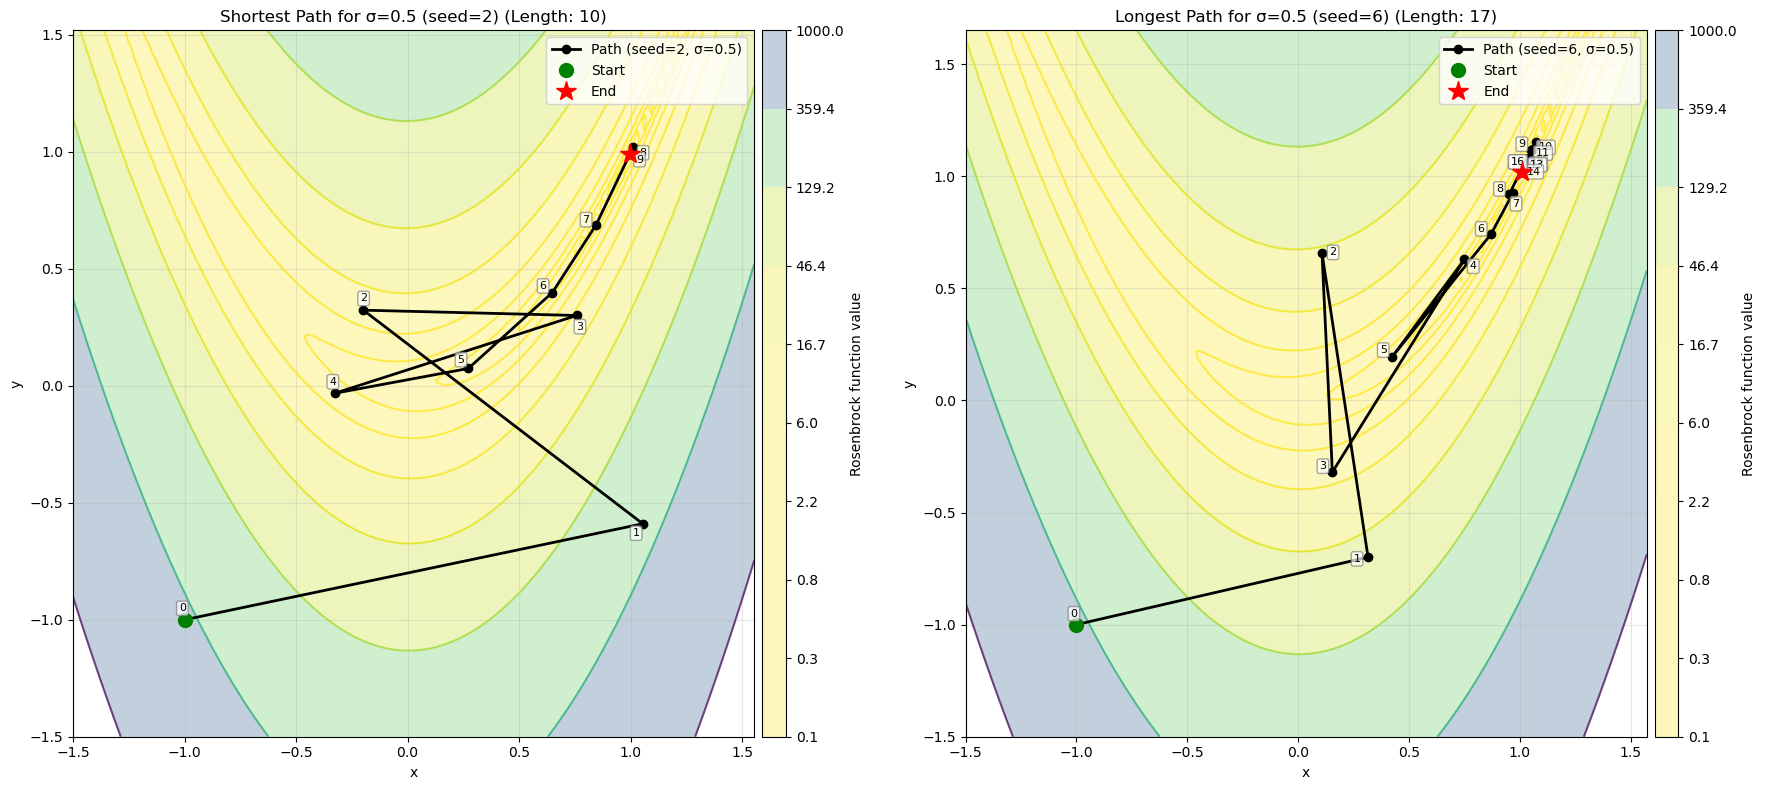

In [15]:
# Find the shortest and longest paths for sigma=0.5
sigma_05_data = [(k, v) for k, v in store_path_dict.items() if k[1] == 0.5]
shortest_path_05 = min(sigma_05_data, key=lambda x: len(x[1]))
longest_path_05 = max(sigma_05_data, key=lambda x: len(x[1]))

# Print information about these paths
print(f"Shortest path for sigma=0.5: seed={shortest_path_05[0][0]}, length={len(shortest_path_05[1])}")
print(f"Longest path for sigma=0.5: seed={longest_path_05[0][0]}, length={len(longest_path_05[1])}")

# Plot these paths
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Reuse the plot_path_with_iterations function from previous cell
def plot_path_with_iterations(path, params, ax, title):
    # Set the range for the contour plot
    x_min_plot = min(path[:, 0]) - 0.5
    x_max_plot = max(path[:, 0]) + 0.5
    y_min_plot = min(path[:, 1]) - 0.5
    y_max_plot = max(path[:, 1]) + 0.5

    # Create a grid of points
    x_grid = np.linspace(x_min_plot, x_max_plot, 100)
    y_grid = np.linspace(y_min_plot, y_max_plot, 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Calculate the Rosenbrock function value for each point
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = rosenbrock(np.array([X[i, j], Y[i, j]]))

    # Create a contour plot with logarithmic scale
    contour_levels = np.logspace(-1, 3, 10)
    contour = ax.contour(X, Y, Z, levels=contour_levels, cmap='viridis_r', alpha=0.7)
    cf = ax.contourf(X, Y, Z, levels=contour_levels, cmap='viridis_r', alpha=0.3)
    
    # Plot the path as a black line with markers
    ax.plot(path[:, 0], path[:, 1], 'k-o', linewidth=2, markersize=6, 
         label=f'Path (seed={params[0]}, σ={params[1]})')
    
    # Mark iterations with numbers, with slight offset for better visibility
    for i, (x, y) in enumerate(path):
        # Calculate offset direction based on path direction
        if i < len(path) - 1:
            dx = path[i+1, 0] - x
            dy = path[i+1, 1] - y
        else:
            dx = x - path[i-1, 0]
            dy = y - path[i-1, 1]
            
        # Normalize and apply offset
        norm = np.sqrt(dx**2 + dy**2) + 1e-10  # Avoid division by zero
        offset_x = 0.05 * (-dy/norm)
        offset_y = 0.05 * (dx/norm)
        
        ax.annotate(str(i), (x + offset_x, y + offset_y), fontsize=8, ha='center', va='center', 
                   bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7))
    
    # Mark the start and end points
    ax.plot(path[0, 0], path[0, 1], 'go', markersize=10, label='Start')
    ax.plot(path[-1, 0], path[-1, 1], 'r*', markersize=15, label='End', zorder=10)
    
    # Add title and labels
    ax.set_title(f'{title} (Length: {len(path)})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return cf

# Plot the shortest path on the first subplot
cf0 = plot_path_with_iterations(shortest_path_05[1], shortest_path_05[0], ax[0], 
                               f'Shortest Path for σ=0.5 (seed={shortest_path_05[0][0]})')

# Plot the longest path on the second subplot
cf1 = plot_path_with_iterations(longest_path_05[1], longest_path_05[0], ax[1], 
                               f'Longest Path for σ=0.5 (seed={longest_path_05[0][0]})')

# Add colorbars
cbar0 = fig.colorbar(cf0, ax=ax[0], pad=0.01, aspect=30, label='Rosenbrock function value')
cbar1 = fig.colorbar(cf1, ax=ax[1], pad=0.01, aspect=30, label='Rosenbrock function value')

plt.tight_layout()
plt.show()